# Biometric Fingerprint Recognition - Demonstration

This notebook demonstrates the full functionality of the Biometric Fingerprint Recognition project. It includes the following sections:

1. Introduction and Setup
2. Morphological Skeletonization and Ridge Connection
3. KMM Thinning with and without Pre/Post-processing
4. Core and Delta Detection using Morphological Skeletonization
5. Minutiae Detection (Bifurcations and Endings) using Morphological Skeletonization
6. Comparison of Morphological and KMM Skeletonization Methods


## 1. Introduction and Setup

Let's start by importing all the necessary libraries and functions.


In [1]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Import project-specific functions
from src.stitching.kmm import kmm_thinning, preprocess_image, postprocess_image
from src.stitching.morphorogical_skeletonization import morphological_skeletonization
from src.improvement.connect_broken_fingerprint_ridges import connect_broken_fingerprint_ridges
from src.detect_minutiae.detect_minutiae import (
    detect_minutiae, 
    draw_minutiae, 
    improved_detect_minutiae, 
    improved_draw_minutiae, 
    detect_cores_deltas
)

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'


Let's load our test images that we'll use throughout this demonstration.


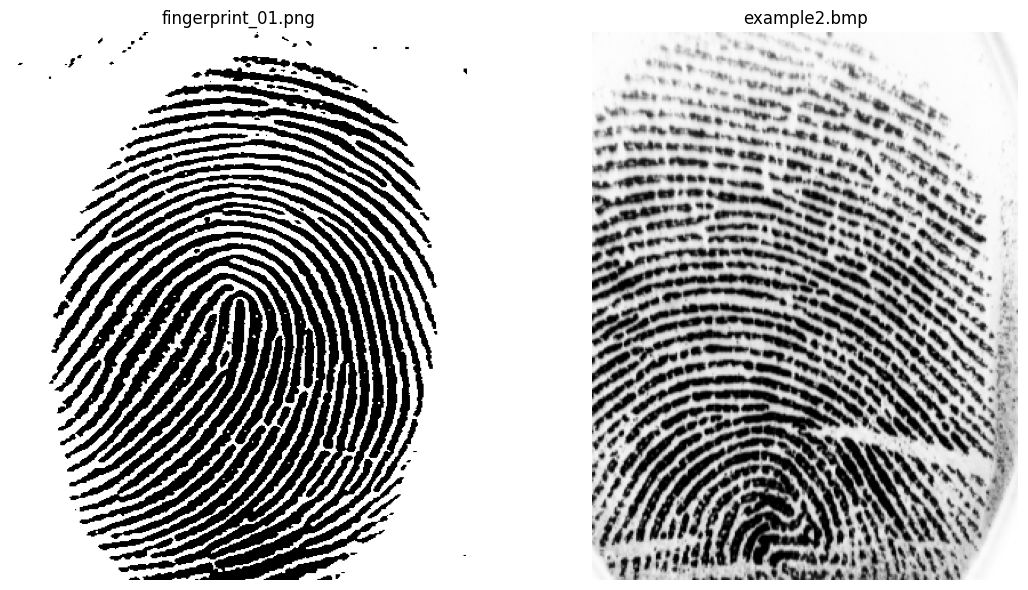

In [3]:
# Load the main test image
fingerprint_01 = cv2.imread("data/fingerprint_01.png", cv2.IMREAD_GRAYSCALE)

# Load the secondary test image for comparison
example2 = cv2.imread("data/example2.bmp", cv2.IMREAD_GRAYSCALE)

# Display the original images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(fingerprint_01, cmap='gray')
axes[0].set_title('fingerprint_01.png')
axes[0].axis('off')

axes[1].imshow(example2, cmap='gray')
axes[1].set_title('example2.bmp')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 2. Morphological Skeletonization and Ridge Connection

In this section, we'll demonstrate the morphological skeletonization algorithm and how it can be improved using the ridge connection function.


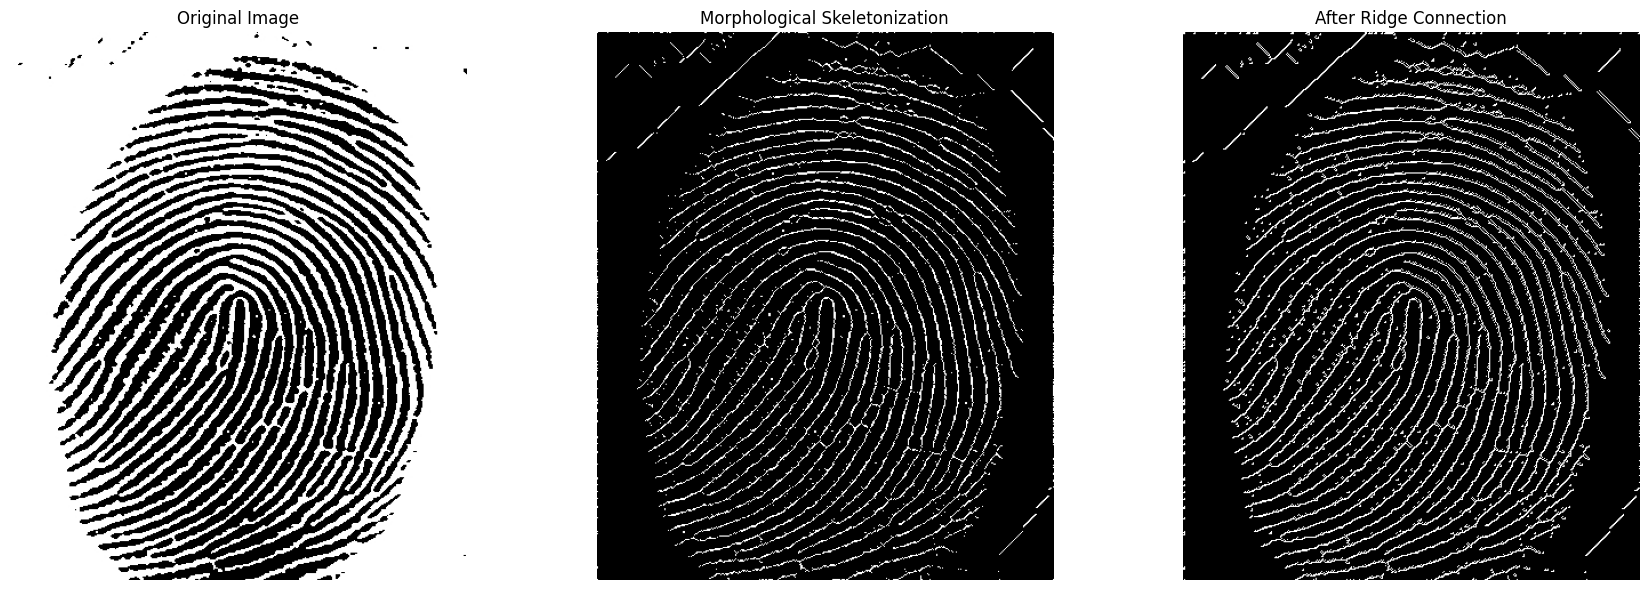

In [3]:
# Apply morphological skeletonization to fingerprint_01
skeleton_result = morphological_skeletonization(fingerprint_01, threshold_value=100)

# Apply ridge connection to improve the skeleton
improved_skeleton = connect_broken_fingerprint_ridges(skeleton_result)

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(fingerprint_01, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(skeleton_result, cmap='gray')
axes[1].set_title('Morphological Skeletonization')
axes[1].axis('off')

axes[2].imshow(improved_skeleton, cmap='gray')
axes[2].set_title('After Ridge Connection')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### Detailed Explanation of Morphological Skeletonization

Morphological skeletonization is a process that reduces binary shapes to a single-pixel-wide representation while preserving the topological properties of the original shape. The algorithm works by iteratively applying morphological operations (erosion and opening) until the image cannot be further thinned without losing connectivity.

The formula used is:
- S_k(X) = (X eroded by kB) - ((X eroded by kB) opened by B)
- Skeleton(X) = Union of S_k(X) for k=0...K
- where K = max{k | X eroded by kB != empty set}

Let's visualize the intermediate steps of the skeletonization process:


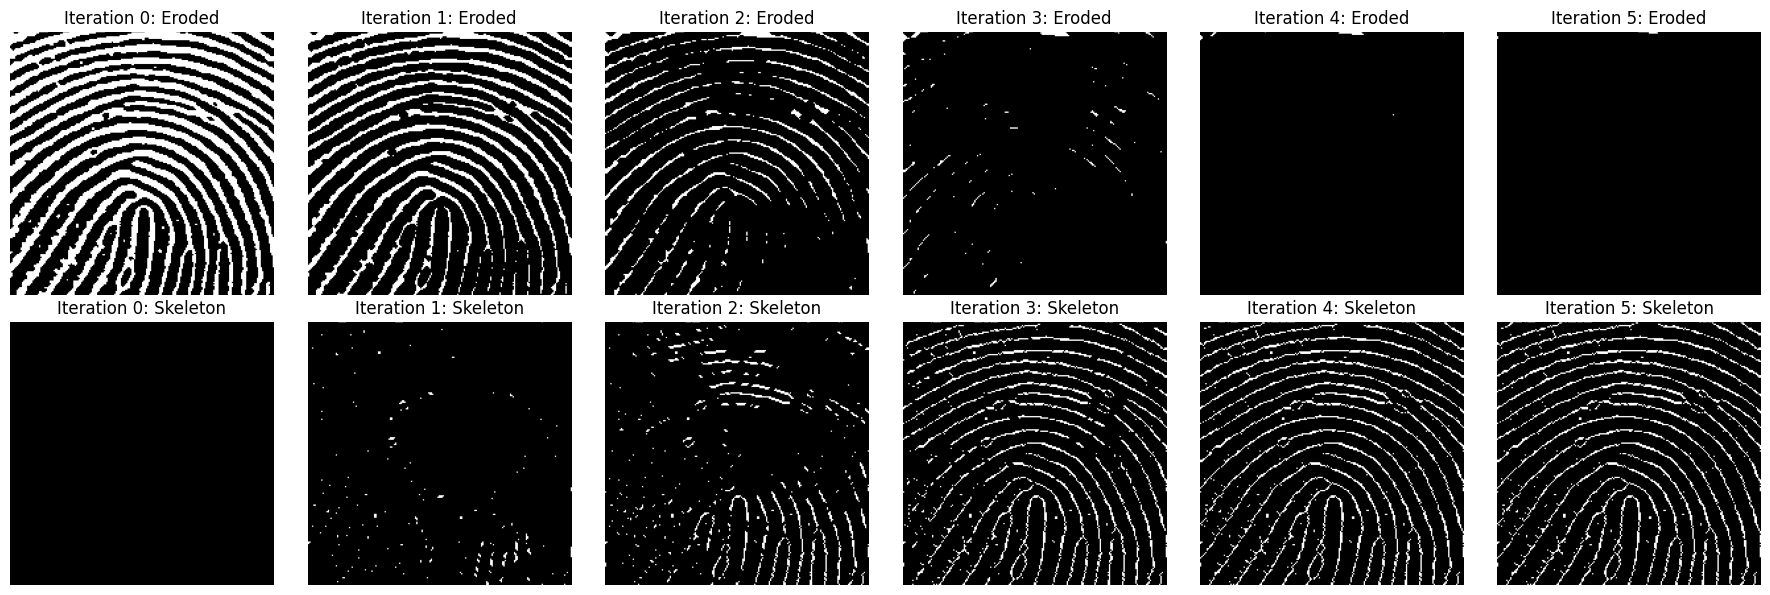

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(200, 200), dtype=uint8)

In [4]:
def visualize_skeletonization_steps(image, threshold_value=100, max_iterations=5):
    """Visualize the intermediate steps of morphological skeletonization"""
    # Ensure proper binary format
    processed_image = image.copy()
    if len(processed_image.shape) == 3:
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
    
    # Binarize the image
    _, binary_image = cv2.threshold(processed_image, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Define the structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    
    # Initialize the skeleton
    skeleton = np.zeros(binary_image.shape, np.uint8)
    eroded_image = binary_image.copy()
    
    # Store intermediate results
    steps = [binary_image.copy()]
    skeletons = [skeleton.copy()]
    
    # Iterative skeletonization
    for i in range(max_iterations):
        # Check if the image is empty
        if cv2.countNonZero(eroded_image) == 0:
            break
        
        # Calculate S_k(X)
        opened_version = cv2.morphologyEx(eroded_image, cv2.MORPH_OPEN, kernel)
        sk_element = cv2.subtract(eroded_image, opened_version)
        skeleton = cv2.bitwise_or(skeleton, sk_element)
        
        # Erode for next iteration
        eroded_image = cv2.erode(eroded_image, kernel)
        
        # Store intermediate results
        steps.append(eroded_image.copy())
        skeletons.append(skeleton.copy())
    
    # Visualize the steps
    num_steps = len(steps)
    fig, axes = plt.subplots(2, num_steps, figsize=(num_steps*3, 6))
    
    for i in range(num_steps):
        axes[0, i].imshow(steps[i], cmap='gray')
        axes[0, i].set_title(f'Iteration {i}: Eroded')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(skeletons[i], cmap='gray')
        axes[1, i].set_title(f'Iteration {i}: Skeleton')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return skeleton

# Visualize the skeletonization steps on a smaller region for clarity
# Extract a region of interest from the fingerprint
roi = fingerprint_01[100:300, 100:300]
visualize_skeletonization_steps(roi)


### Detailed Explanation of Ridge Connection

The ridge connection algorithm is designed to improve the quality of the skeletonized fingerprint by connecting broken ridges. It works by applying morphological operations (erosion and dilation) to modify the image based on pixel neighborhoods.

Let's visualize how the ridge connection algorithm works:


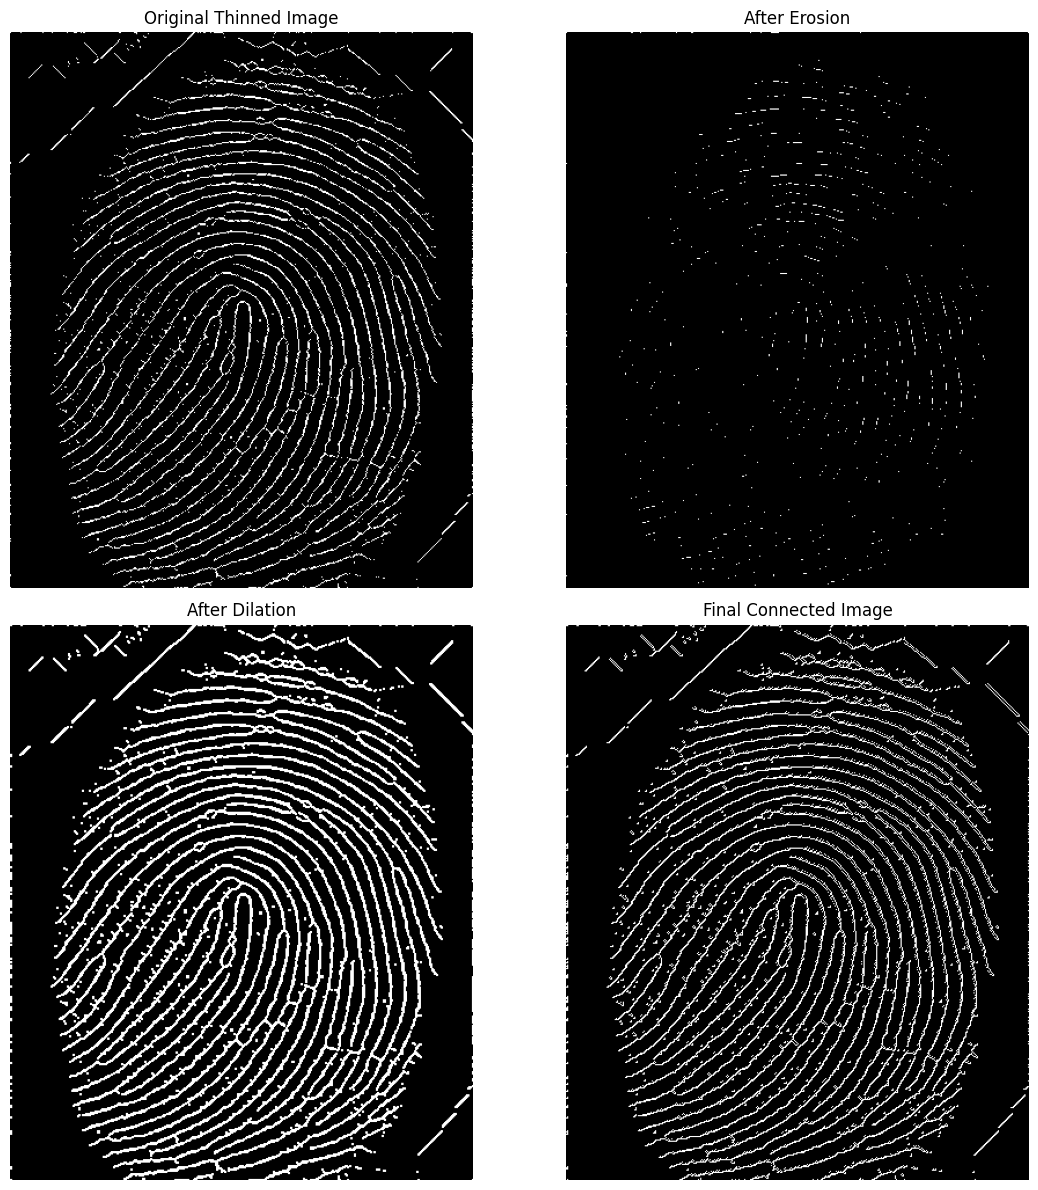

array([[255, 255,   0, ...,   0,   0, 255],
       [255, 255,   0, ...,   0, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0]], shape=(480, 400), dtype=uint8)

In [5]:
def visualize_ridge_connection(thinned_image):
    """Visualize the ridge connection process"""
    # Make a copy of the input image
    output_image = thinned_image.copy()
    
    # Define the kernel for morphological operations
    kernel = np.ones((2, 2), np.uint8)
    
    # Apply erosion to identify white pixels with black neighbors
    eroded_image = cv2.erode(thinned_image, kernel, iterations=1)
    
    # Apply dilation to identify black pixels with white neighbors
    dilated_image = cv2.dilate(thinned_image, kernel, iterations=1)
    
    # Apply the ridge connection logic
    output_image = np.where(thinned_image == 255, eroded_image, dilated_image)
    
    # Visualize the process
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    axes[0, 0].imshow(thinned_image, cmap='gray')
    axes[0, 0].set_title('Original Thinned Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(eroded_image, cmap='gray')
    axes[0, 1].set_title('After Erosion')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(dilated_image, cmap='gray')
    axes[1, 0].set_title('After Dilation')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(output_image, cmap='gray')
    axes[1, 1].set_title('Final Connected Image')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return output_image

# Visualize the ridge connection process on the skeletonized image
visualize_ridge_connection(skeleton_result)


## 3. KMM Thinning with and without Pre/Post-processing

In this section, we'll demonstrate the KMM (Kang-Wang-Morelli) thinning algorithm with and without preprocessing and postprocessing.


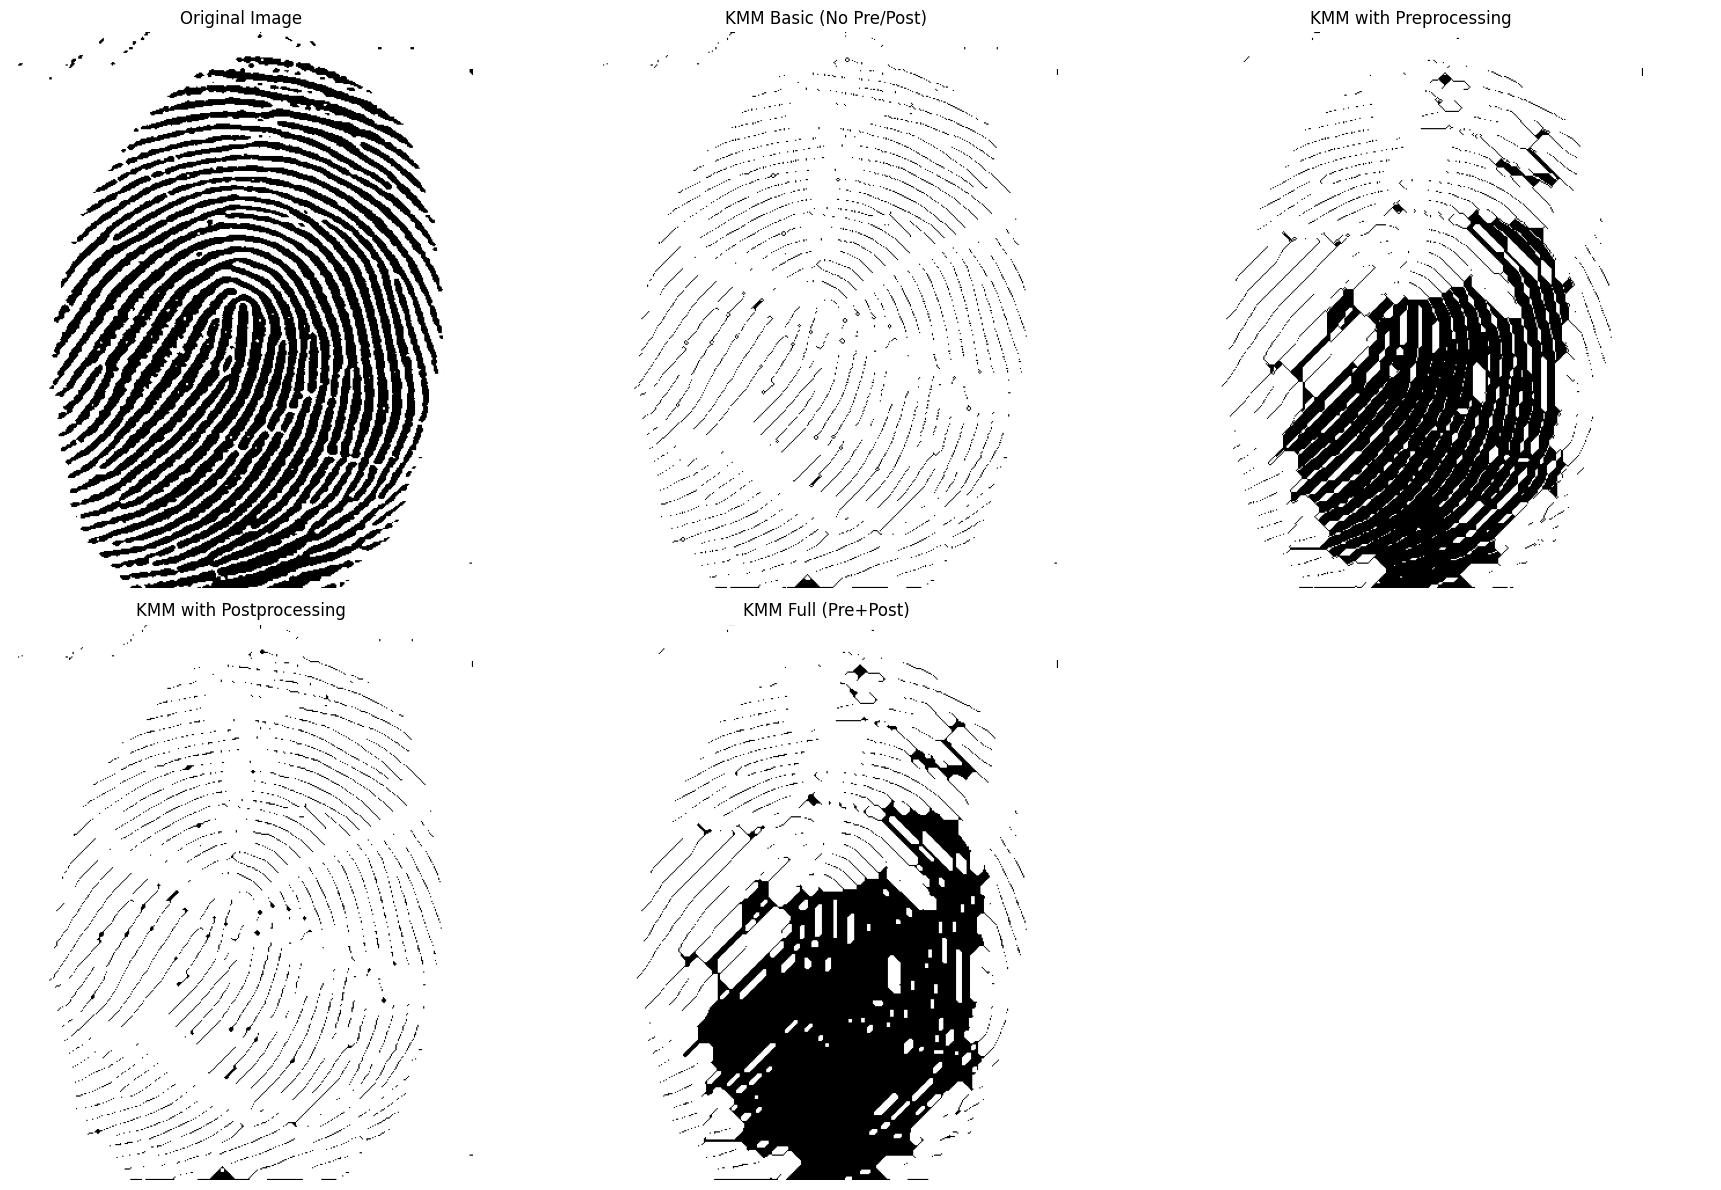

In [6]:
# Define a function to test KMM thinning with different configurations
def test_kmm_configurations(input_image_path):
    # KMM without preprocessing or postprocessing
    kmm_basic = kmm_thinning(input_image_path, None, apply_preprocessing=False, apply_postprocessing=False)
    
    # KMM with preprocessing only
    kmm_preproc = kmm_thinning(input_image_path, None, apply_preprocessing=True, apply_postprocessing=False)
    
    # KMM with postprocessing only
    kmm_postproc = kmm_thinning(input_image_path, None, apply_preprocessing=False, apply_postprocessing=True)
    
    # KMM with both preprocessing and postprocessing
    kmm_full = kmm_thinning(input_image_path, None, apply_preprocessing=True, apply_postprocessing=True)
    
    # Load the original image for comparison
    original = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Display the results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(kmm_basic, cmap='gray')
    axes[0, 1].set_title('KMM Basic (No Pre/Post)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(kmm_preproc, cmap='gray')
    axes[0, 2].set_title('KMM with Preprocessing')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(kmm_postproc, cmap='gray')
    axes[1, 0].set_title('KMM with Postprocessing')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(kmm_full, cmap='gray')
    axes[1, 1].set_title('KMM Full (Pre+Post)')
    axes[1, 1].axis('off')
    
    # Leave one subplot empty
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return kmm_basic, kmm_preproc, kmm_postproc, kmm_full

# Test KMM configurations on fingerprint_01.png
kmm_basic, kmm_preproc, kmm_postproc, kmm_full = test_kmm_configurations("data/fingerprint_01.png")


### Detailed Explanation of KMM Thinning

The KMM (Kang-Wang-Morelli) thinning algorithm is a method for reducing binary shapes to a single-pixel-wide representation. It works by iteratively identifying and removing contour pixels while preserving the connectivity of the image.

Let's examine the preprocessing and postprocessing steps in more detail:


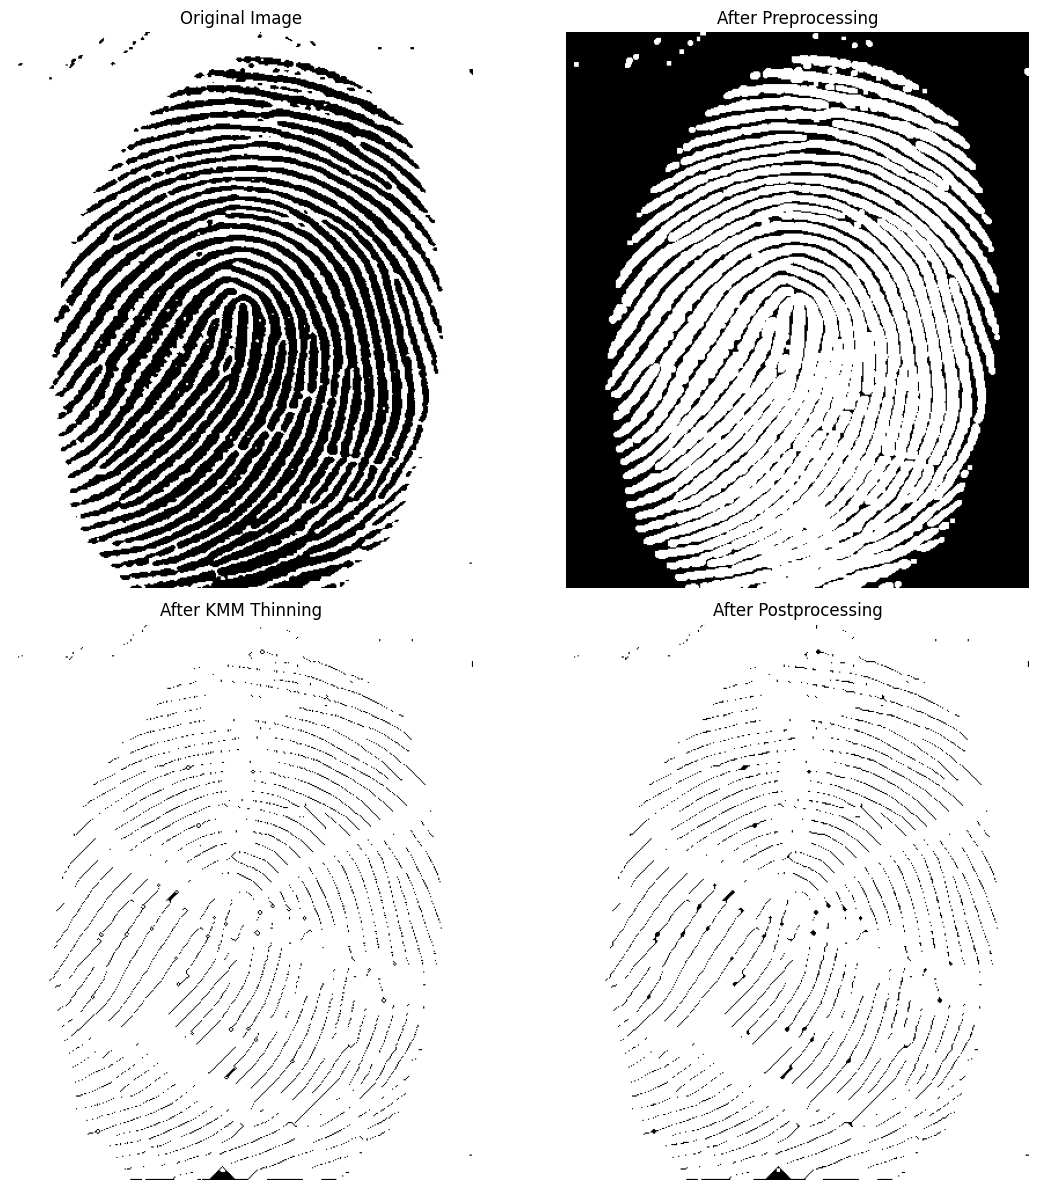

In [7]:
# Load the original image
original = cv2.imread("data/fingerprint_01.png", cv2.IMREAD_GRAYSCALE)

# Convert to binary format expected by the preprocessing function (0 for background, 1 for foreground)
binary = np.where(original < 128, 1, 0)

# Apply preprocessing
preprocessed_binary = preprocess_image(binary, noise_removal=True, dilation=True, kernel_size=3)

# Convert back to OpenCV format for visualization (0 for black, 255 for white)
preprocessed = np.where(preprocessed_binary == 1, 255, 0).astype(np.uint8)

# Apply KMM thinning to the preprocessed image
thinned = kmm_thinning("data/fingerprint_01.png", None, apply_preprocessing=False, apply_postprocessing=False)

# Apply postprocessing to the thinned image
postprocessed = postprocess_image(thinned, closing=True, bridging=True, kernel_size=3)

# Display the preprocessing and postprocessing steps
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(preprocessed, cmap='gray')
axes[0, 1].set_title('After Preprocessing')
axes[0, 1].axis('off')

axes[1, 0].imshow(thinned, cmap='gray')
axes[1, 0].set_title('After KMM Thinning')
axes[1, 0].axis('off')

axes[1, 1].imshow(postprocessed, cmap='gray')
axes[1, 1].set_title('After Postprocessing')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


## 4. Core and Delta Detection using Morphological Skeletonization

In this section, we'll demonstrate how to detect cores and deltas in a fingerprint image using morphological skeletonization.


Valid orientation blocks: 2069/3000


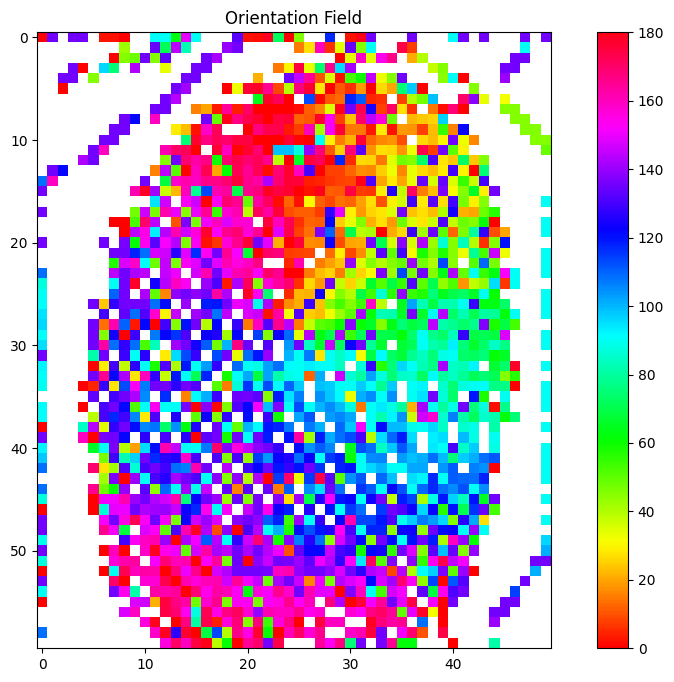

Core candidates found: 105
Delta candidates found: 83


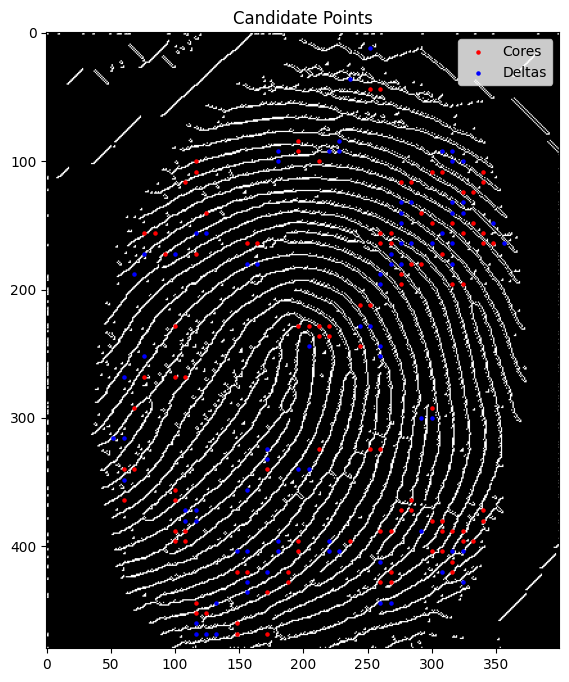

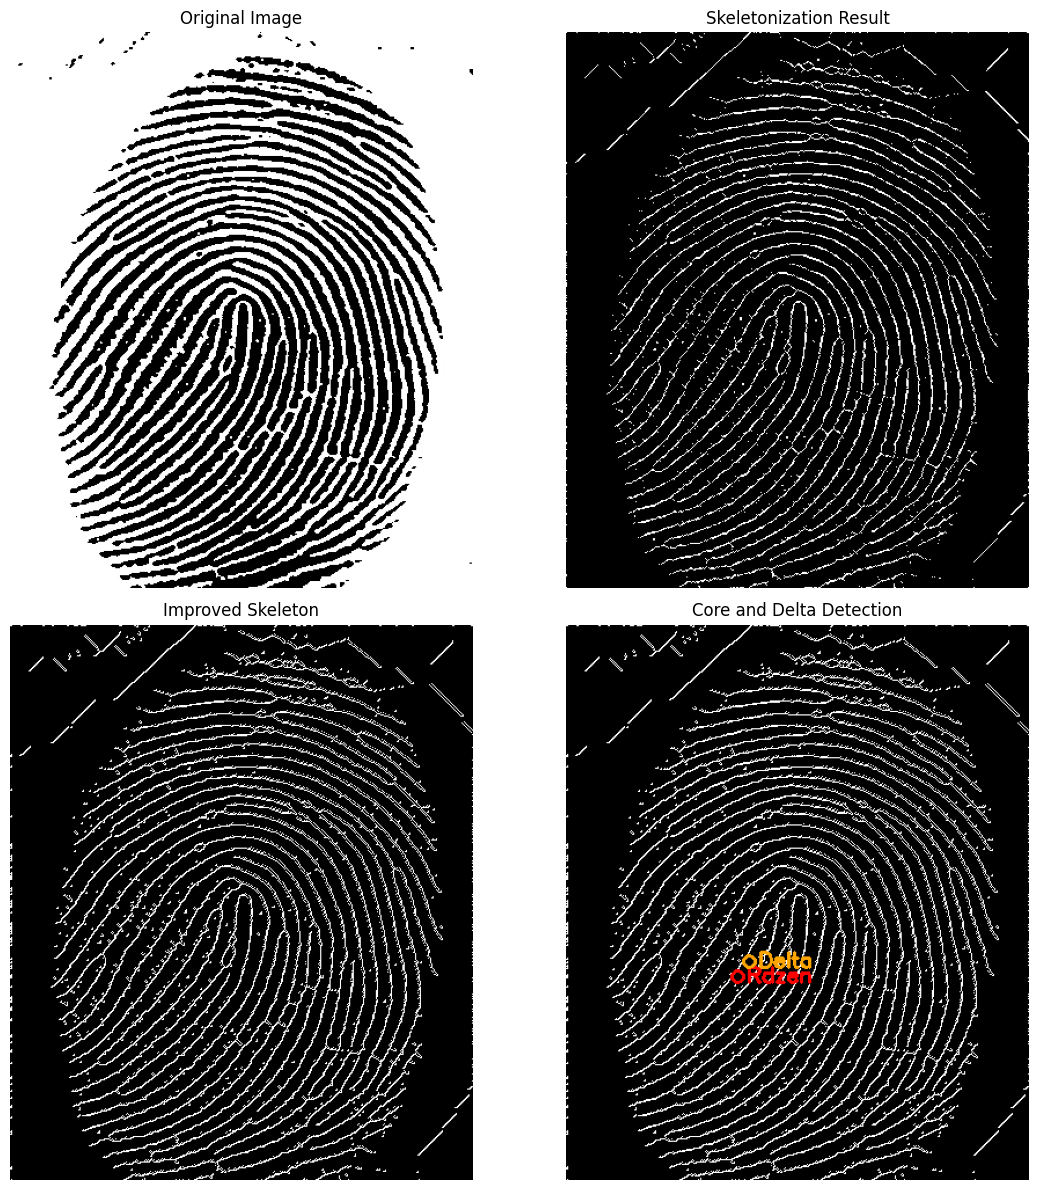

In [8]:
# Apply morphological skeletonization
skeleton_result = morphological_skeletonization(fingerprint_01, threshold_value=100)

# Apply ridge connection to improve the skeleton
improved_skeleton = connect_broken_fingerprint_ridges(skeleton_result)

# Detect cores and deltas
block_size = 8
eps = 3 * block_size
minutiae_data = detect_cores_deltas(improved_skeleton, cluster_eps=eps, block_size=block_size, debug=True)

# Draw the detected minutiae on the image
result_minutiae = improved_draw_minutiae(improved_skeleton, minutiae_data, show_labels=True)

# Display the results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(fingerprint_01, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(skeleton_result, cmap='gray')
axes[0, 1].set_title('Skeletonization Result')
axes[0, 1].axis('off')

axes[1, 0].imshow(improved_skeleton, cmap='gray')
axes[1, 0].set_title('Improved Skeleton')
axes[1, 0].axis('off')

axes[1, 1].imshow(result_minutiae, cmap='gray')
axes[1, 1].set_title('Core and Delta Detection')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


### Detailed Explanation of Core and Delta Detection

Cores and deltas are special points in a fingerprint that are used for classification and matching. The detection of these points is based on the Poincare index, which measures the cumulative orientation change around a point.

Let's visualize the orientation field and the Poincare index calculation:


Valid orientation blocks: 2069/3000


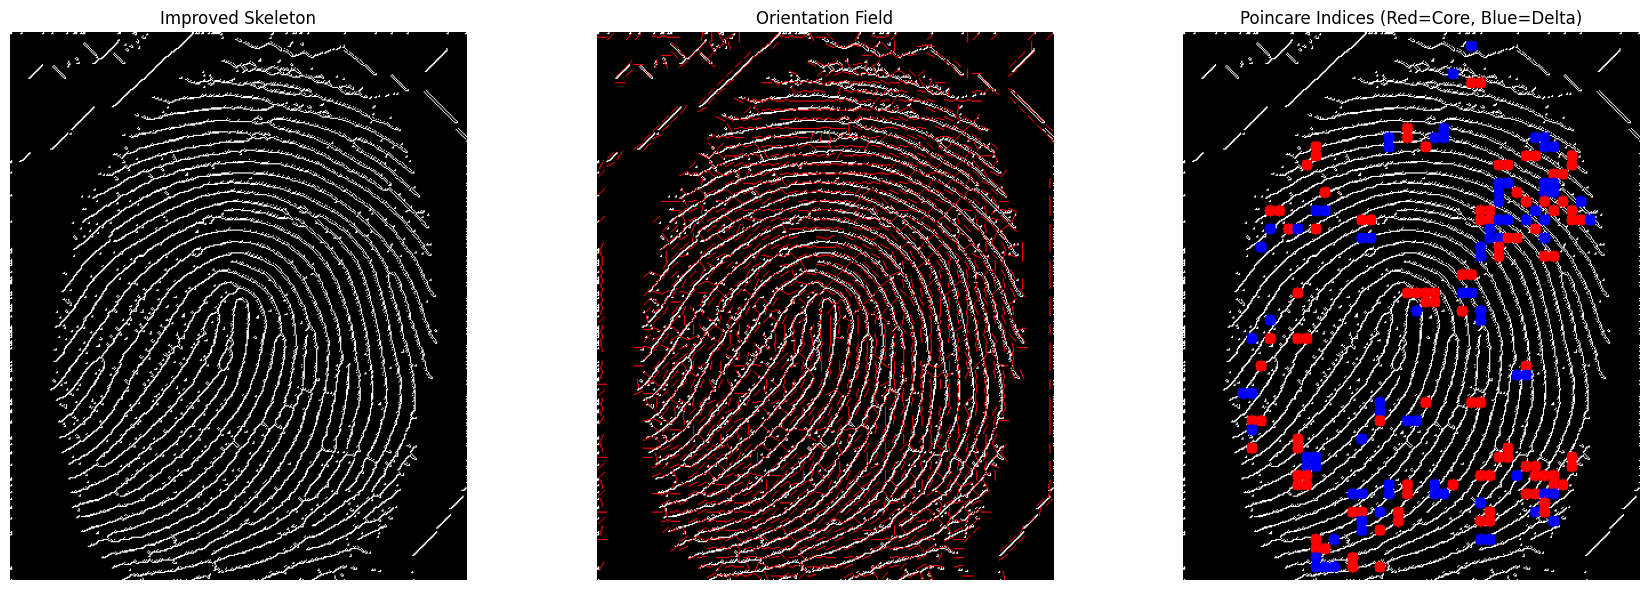

In [9]:
from src.detect_minutiae.detect_minutiae import compute_orientation_blocks, compute_poincare_index

# Compute the orientation field
orientations = compute_orientation_blocks(improved_skeleton, block_size=8)

# Create a visualization of the orientation field
def visualize_orientation_field(image, orientations, block_size=8):
    h, w = image.shape
    vis_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(orientations.shape[0]):
        for j in range(orientations.shape[1]):
            if np.isnan(orientations[i, j]):
                continue
                
            # Calculate the center of the block
            center_y = i * block_size + block_size // 2
            center_x = j * block_size + block_size // 2
            
            # Calculate the orientation in radians
            theta = np.radians(orientations[i, j])
            
            # Calculate the line endpoints
            length = block_size // 2
            x1 = int(center_x - length * np.cos(theta))
            y1 = int(center_y - length * np.sin(theta))
            x2 = int(center_x + length * np.cos(theta))
            y2 = int(center_y + length * np.sin(theta))
            
            # Draw the orientation line
            cv2.line(vis_image, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
    return vis_image

# Visualize the orientation field
orientation_vis = visualize_orientation_field(improved_skeleton, orientations, block_size=8)

# Compute the Poincare index for each block
poincare_indices = np.zeros(orientations.shape)
for i in range(1, orientations.shape[0]-1):
    for j in range(1, orientations.shape[1]-1):
        if not np.isnan(orientations[i, j]):
            poincare_indices[i, j] = compute_poincare_index(orientations, i, j)

# Create a visualization of the Poincare indices
def visualize_poincare_indices(image, poincare_indices, block_size=8):
    h, w = image.shape
    vis_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(poincare_indices.shape[0]):
        for j in range(poincare_indices.shape[1]):
            if poincare_indices[i, j] == 0:
                continue
                
            # Calculate the center of the block
            center_y = i * block_size + block_size // 2
            center_x = j * block_size + block_size // 2
            
            # Draw a circle for core (red) or delta (blue)
            if poincare_indices[i, j] == 1:  # Core
                cv2.circle(vis_image, (center_x, center_y), 5, (0, 0, 255), -1)
            elif poincare_indices[i, j] == -1:  # Delta
                cv2.circle(vis_image, (center_x, center_y), 5, (255, 0, 0), -1)
    
    return vis_image

# Visualize the Poincare indices
poincare_vis = visualize_poincare_indices(improved_skeleton, poincare_indices, block_size=8)

# Display the visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(improved_skeleton, cmap='gray')
axes[0].set_title('Improved Skeleton')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(orientation_vis, cv2.COLOR_BGR2RGB))
axes[1].set_title('Orientation Field')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(poincare_vis, cv2.COLOR_BGR2RGB))
axes[2].set_title('Poincare Indices (Red=Core, Blue=Delta)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## 5. Minutiae Detection (Bifurcations and Endings) using Morphological Skeletonization

In this section, we'll demonstrate how to detect minutiae (bifurcations and endings) in a fingerprint image using morphological skeletonization.


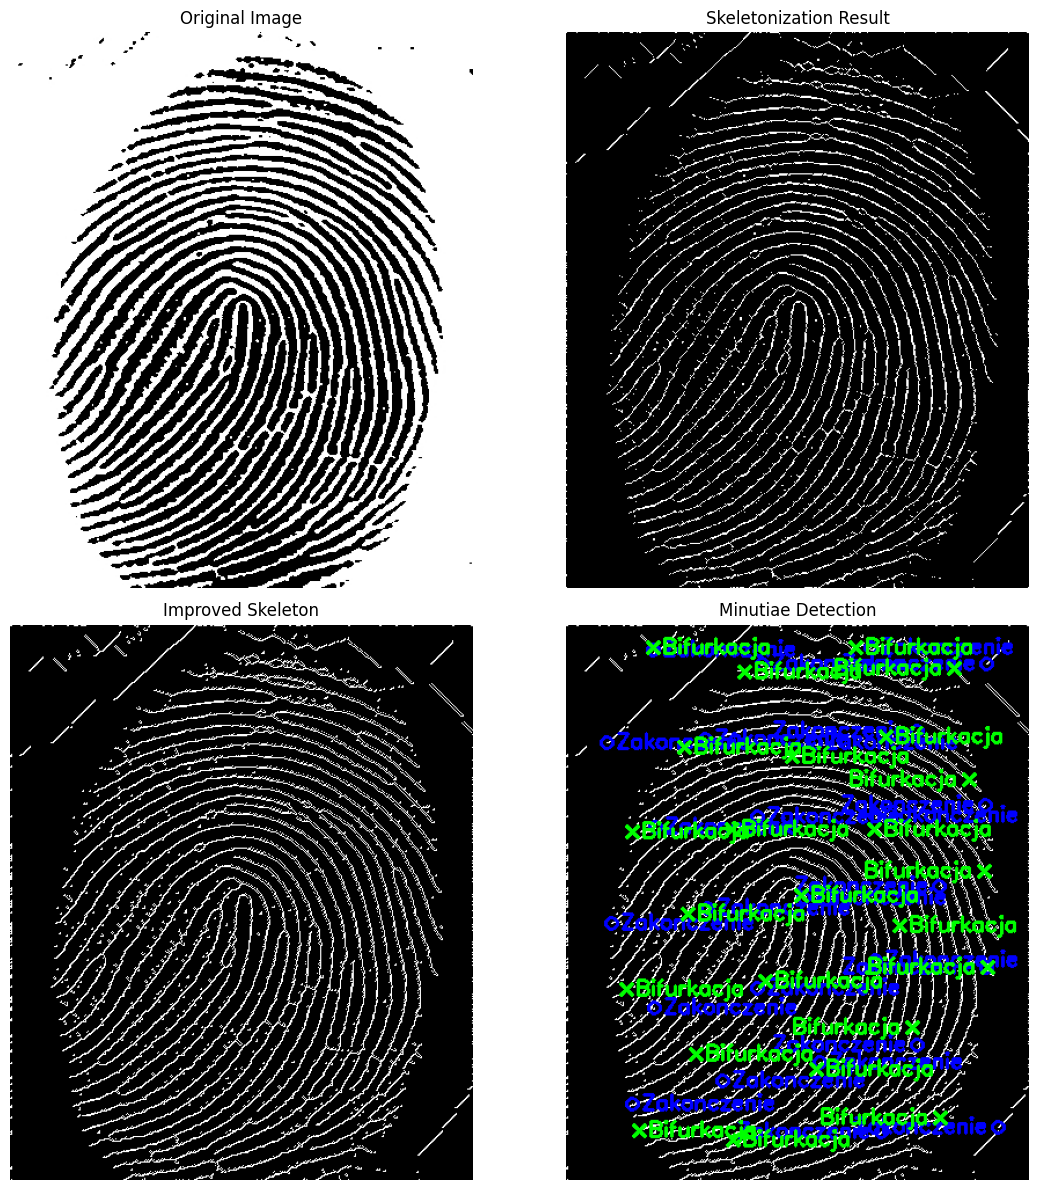

In [4]:
# Apply morphological skeletonization
skeleton_result = morphological_skeletonization(fingerprint_01, threshold_value=100)

# Apply ridge connection to improve the skeleton
improved_skeleton = connect_broken_fingerprint_ridges(skeleton_result)

# Detect minutiae (bifurcations and endings)
minutiae_data = detect_minutiae(improved_skeleton, border_margin=20, min_distance=80)

# Draw the detected minutiae on the image
result_minutiae = improved_draw_minutiae(improved_skeleton, minutiae_data, show_labels=True)

# Display the results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(fingerprint_01, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(skeleton_result, cmap='gray')
axes[0, 1].set_title('Skeletonization Result')
axes[0, 1].axis('off')

axes[1, 0].imshow(improved_skeleton, cmap='gray')
axes[1, 0].set_title('Improved Skeleton')
axes[1, 0].axis('off')

axes[1, 1].imshow(result_minutiae, cmap='gray')
axes[1, 1].set_title('Minutiae Detection')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


### Detailed Explanation of Minutiae Detection

Minutiae are the points where fingerprint ridges end or bifurcate (split). The detection of these points is based on the Crossing Number (CN) method, which counts the number of transitions between ridge and valley pixels around a point.

Let's visualize how the Crossing Number method works:


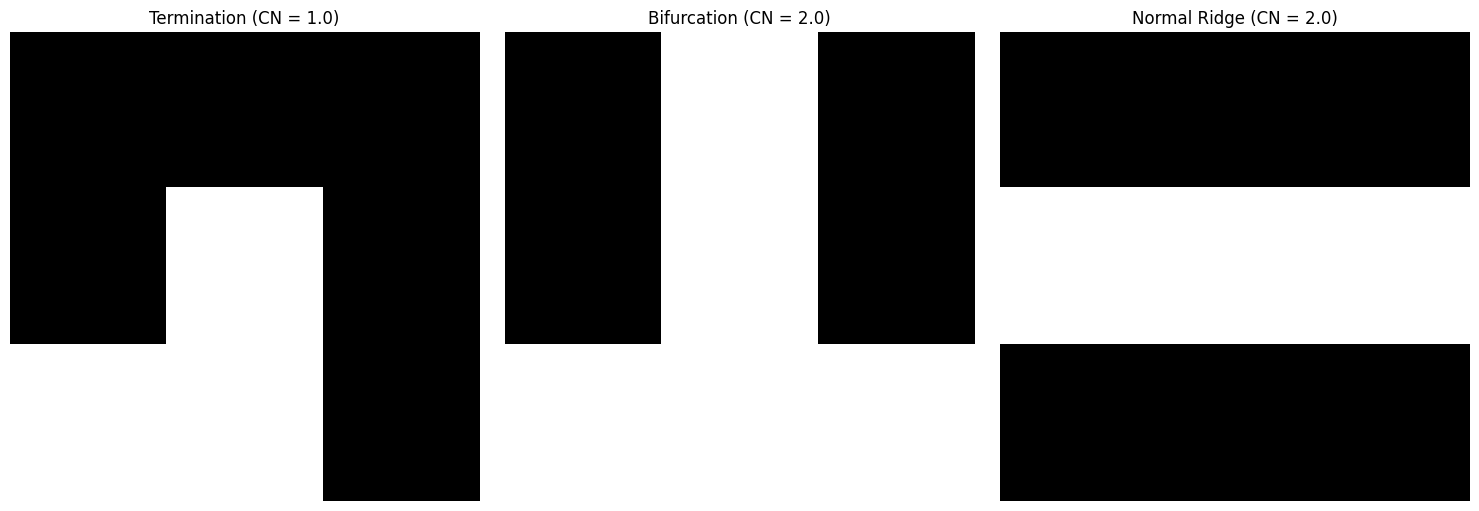

In [5]:
from src.detect_minutiae.detect_minutiae import _calculate_crossing_number

# Create example 3x3 windows for different minutiae types
termination_window = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [1, 1, 0]
])

bifurcation_window = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [1, 1, 1]
])

normal_ridge_window = np.array([
    [0, 0, 0],
    [1, 1, 1],
    [0, 0, 0]
])

# Calculate the crossing numbers
termination_cn = _calculate_crossing_number(termination_window)
bifurcation_cn = _calculate_crossing_number(bifurcation_window)
normal_ridge_cn = _calculate_crossing_number(normal_ridge_window)

# Display the windows and their crossing numbers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(termination_window, cmap='gray')
axes[0].set_title(f'Termination (CN = {termination_cn})')
axes[0].axis('off')

axes[1].imshow(bifurcation_window, cmap='gray')
axes[1].set_title(f'Bifurcation (CN = {bifurcation_cn})')
axes[1].axis('off')

axes[2].imshow(normal_ridge_window, cmap='gray')
axes[2].set_title(f'Normal Ridge (CN = {normal_ridge_cn})')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Now let's visualize the minutiae detection process on a small region of the fingerprint:


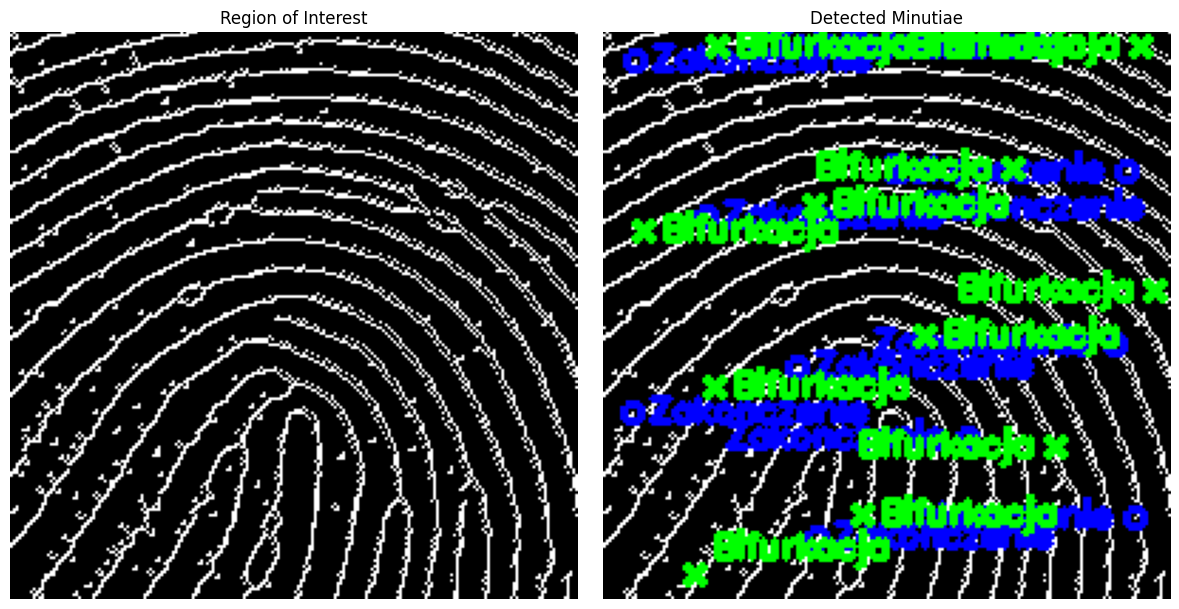

In [7]:
# Extract a region of interest from the improved skeleton
roi = improved_skeleton[100:300, 100:300]

# Detect minutiae in the ROI
roi_minutiae = detect_minutiae(roi, border_margin=5, min_distance=60)

# Draw the detected minutiae on the ROI
roi_result = improved_draw_minutiae(roi, roi_minutiae, show_labels=True, marker_size=3, font_scale=0.4)

# Display the ROI and the detected minutiae
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(roi, cmap='gray')
axes[0].set_title('Region of Interest')
axes[0].axis('off')

axes[1].imshow(roi_result, cmap='gray')
axes[1].set_title('Detected Minutiae')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 6. Comparison of Morphological and KMM Skeletonization Methods

In this section, we'll compare the morphological skeletonization and KMM thinning methods.


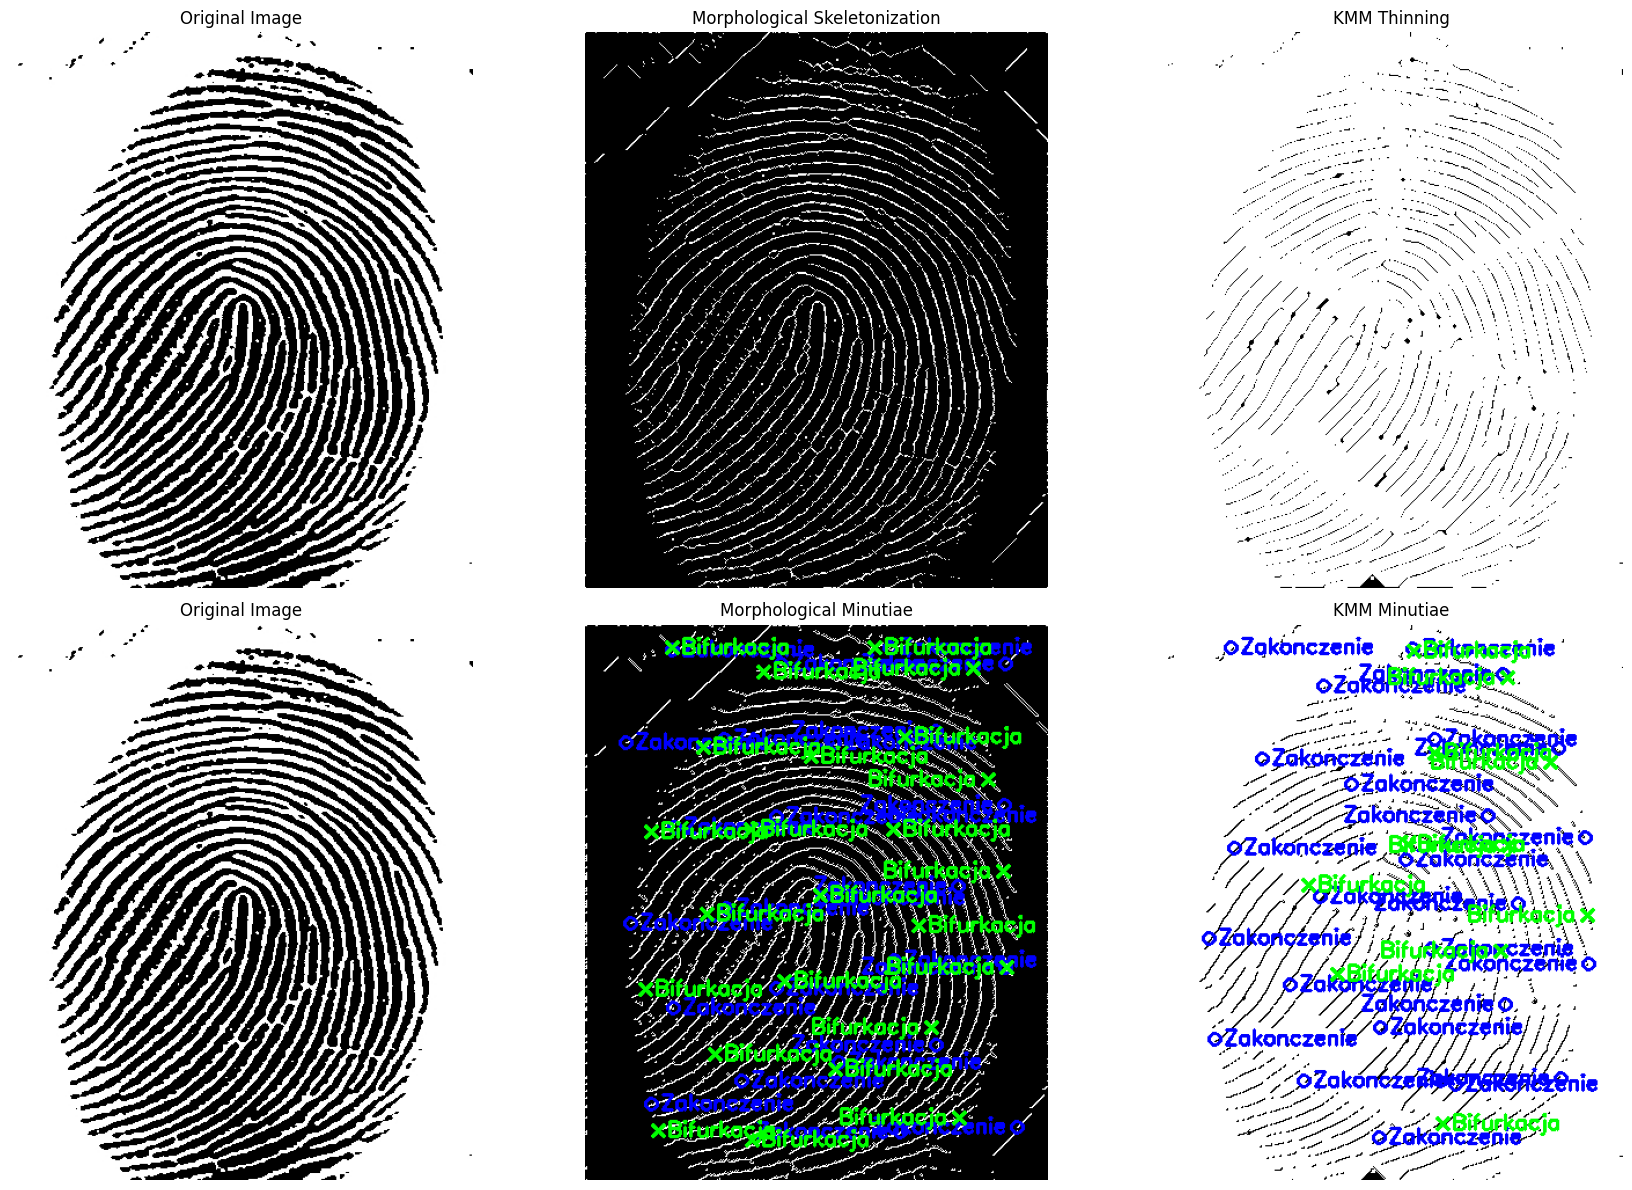

In [8]:
# Apply morphological skeletonization
morph_skeleton = morphological_skeletonization(fingerprint_01, threshold_value=100)

# Apply KMM thinning with full preprocessing and postprocessing
kmm_skeleton = kmm_thinning("data/fingerprint_01.png", None, apply_preprocessing=False, apply_postprocessing=True)

# Apply ridge connection to both skeletons
morph_improved = connect_broken_fingerprint_ridges(morph_skeleton)
kmm_improved = connect_broken_fingerprint_ridges(kmm_skeleton)

# Detect minutiae on both improved skeletons
morph_minutiae = detect_minutiae(morph_improved, border_margin=20, min_distance=80)
kmm_minutiae = detect_minutiae(kmm_improved, border_margin=20, min_distance=80)

# Draw the detected minutiae on both images
morph_result = improved_draw_minutiae(morph_improved, morph_minutiae, show_labels=True)
kmm_result = improved_draw_minutiae(kmm_improved, kmm_minutiae, show_labels=True)

# Display the comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(fingerprint_01, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(morph_skeleton, cmap='gray')
axes[0, 1].set_title('Morphological Skeletonization')
axes[0, 1].axis('off')

axes[0, 2].imshow(kmm_skeleton, cmap='gray')
axes[0, 2].set_title('KMM Thinning')
axes[0, 2].axis('off')

axes[1, 0].imshow(fingerprint_01, cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(morph_result, cmap='gray')
axes[1, 1].set_title('Morphological Minutiae')
axes[1, 1].axis('off')

axes[1, 2].imshow(kmm_result, cmap='gray')
axes[1, 2].set_title('KMM Minutiae')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


### Quantitative Comparison

Let's perform a quantitative comparison of the two skeletonization methods by counting the number of minutiae detected and measuring the processing time.


In [14]:
import time

# Measure the processing time for morphological skeletonization
start_time = time.time()
morph_skeleton = morphological_skeletonization(fingerprint_01, threshold_value=100)
morph_time = time.time() - start_time

# Measure the processing time for KMM thinning
start_time = time.time()
kmm_skeleton = kmm_thinning("data/fingerprint_01.png", None, apply_preprocessing=True, apply_postprocessing=True)
kmm_time = time.time() - start_time

# Count the number of minutiae detected by each method
morph_minutiae = detect_minutiae(morph_improved, border_margin=20, min_distance=80)
kmm_minutiae = detect_minutiae(kmm_improved, border_margin=20, min_distance=80)

morph_terminations = len(morph_minutiae["terminations"])
morph_bifurcations = len(morph_minutiae["bifurcations"])
morph_total = morph_terminations + morph_bifurcations

kmm_terminations = len(kmm_minutiae["terminations"])
kmm_bifurcations = len(kmm_minutiae["bifurcations"])
kmm_total = kmm_terminations + kmm_bifurcations

# Create a comparison table
comparison_data = {
    "Method": ["Morphological", "KMM"],
    "Processing Time (s)": [morph_time, kmm_time],
    "Terminations": [morph_terminations, kmm_terminations],
    "Bifurcations": [morph_bifurcations, kmm_bifurcations],
    "Total Minutiae": [morph_total, kmm_total]
}

# Display the comparison table
from tabulate import tabulate
print(tabulate(comparison_data, headers="keys", tablefmt="grid"))


+---------------+-----------------------+----------------+----------------+------------------+
| Method        |   Processing Time (s) |   Terminations |   Bifurcations |   Total Minutiae |
+===============+=======================+================+================+==================+
| Morphological |             0.0147729 |             26 |             24 |               50 |
+---------------+-----------------------+----------------+----------------+------------------+
| KMM           |            28.805     |             23 |             15 |               38 |
+---------------+-----------------------+----------------+----------------+------------------+


### Visual Comparison on a Second Image

Let's compare the two skeletonization methods on the second test image (example2.bmp).


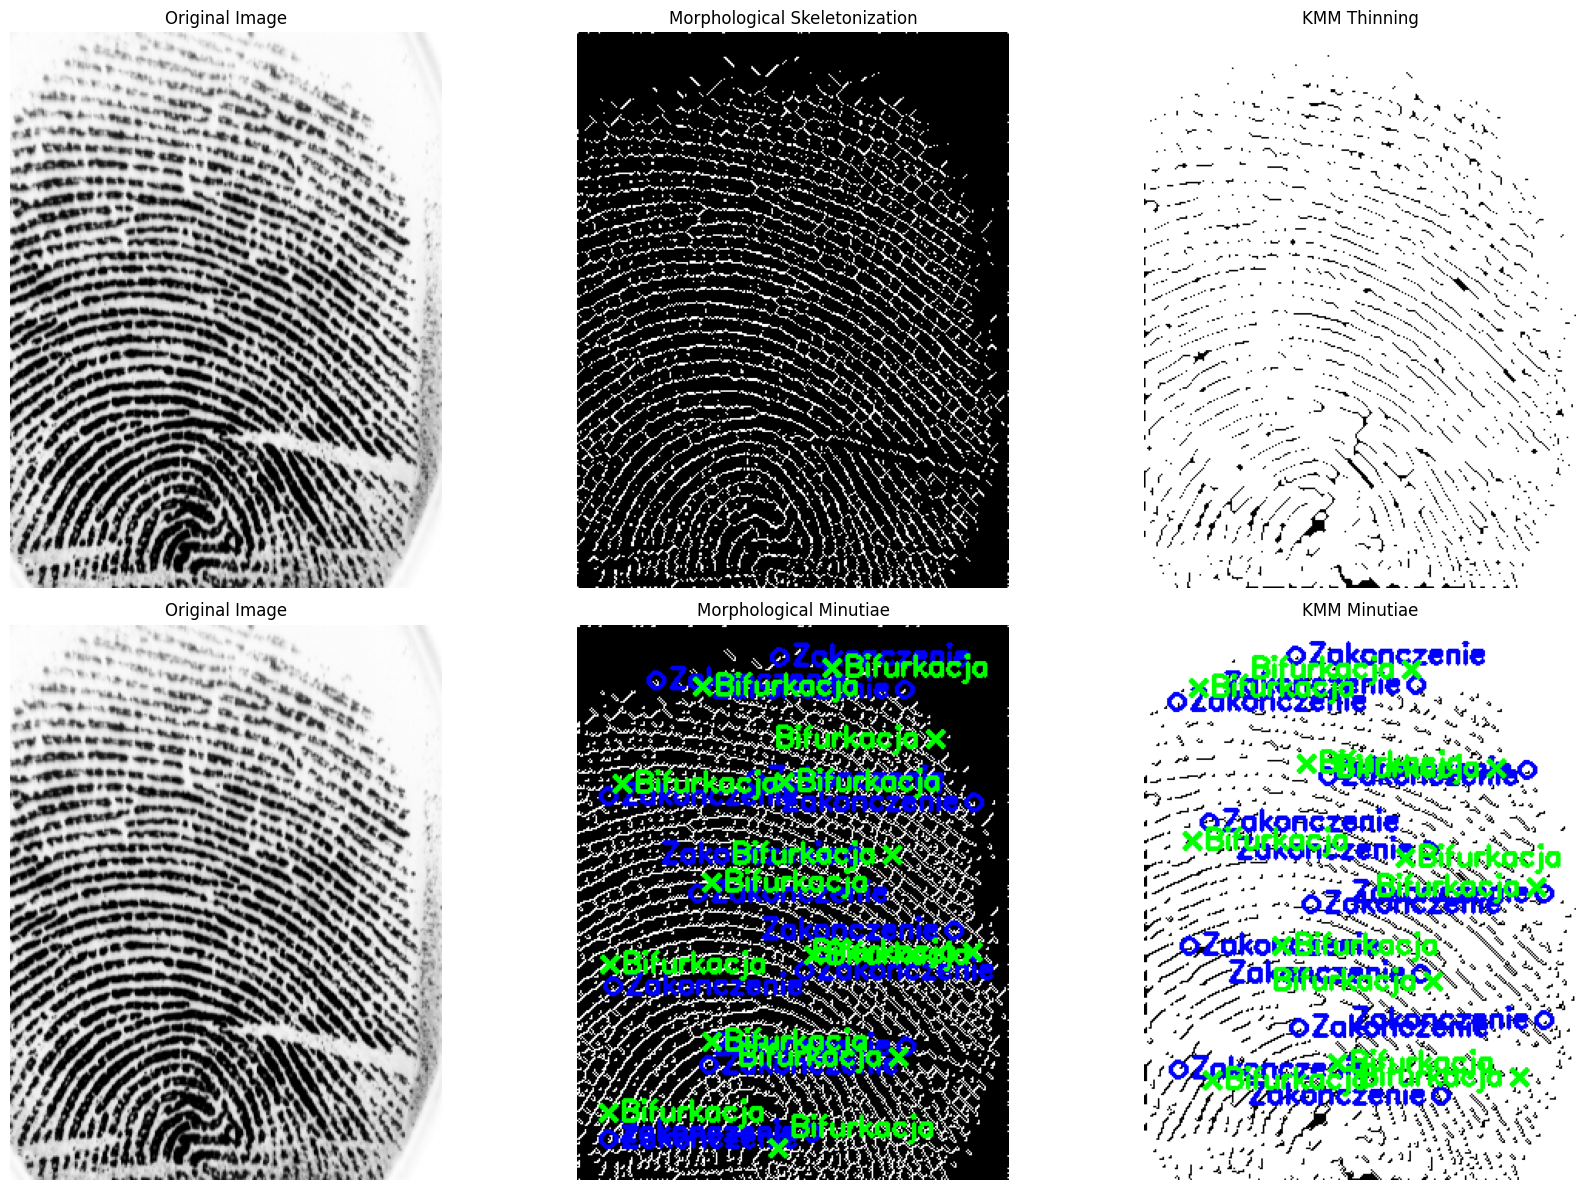

In [9]:
# Apply morphological skeletonization to example2
morph_skeleton2 = morphological_skeletonization(example2, threshold_value=100)

# Apply KMM thinning to example2
kmm_skeleton2 = kmm_thinning("data/example2.bmp", None, apply_preprocessing=False, apply_postprocessing=True)

# Apply ridge connection to both skeletons
morph_improved2 = connect_broken_fingerprint_ridges(morph_skeleton2)
kmm_improved2 = connect_broken_fingerprint_ridges(kmm_skeleton2)

# Detect minutiae on both improved skeletons
morph_minutiae2 = detect_minutiae(morph_improved2, border_margin=20, min_distance=80)
kmm_minutiae2 = detect_minutiae(kmm_improved2, border_margin=20, min_distance=80)

# Draw the detected minutiae on both images
morph_result2 = improved_draw_minutiae(morph_improved2, morph_minutiae2, show_labels=True)
kmm_result2 = improved_draw_minutiae(kmm_improved2, kmm_minutiae2, show_labels=True)

# Display the comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(example2, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(morph_skeleton2, cmap='gray')
axes[0, 1].set_title('Morphological Skeletonization')
axes[0, 1].axis('off')

axes[0, 2].imshow(kmm_skeleton2, cmap='gray')
axes[0, 2].set_title('KMM Thinning')
axes[0, 2].axis('off')

axes[1, 0].imshow(example2, cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(morph_result2, cmap='gray')
axes[1, 1].set_title('Morphological Minutiae')
axes[1, 1].axis('off')

axes[1, 2].imshow(kmm_result2, cmap='gray')
axes[1, 2].set_title('KMM Minutiae')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've demonstrated the full functionality of the Biometric Fingerprint Recognition project. We've shown how to:

1. Apply morphological skeletonization to fingerprint images
2. Improve the skeletonization results using ridge connection
3. Apply KMM thinning with and without preprocessing and postprocessing
4. Detect cores and deltas using the Poincare index
5. Detect minutiae (bifurcations and endings) using the Crossing Number method
6. Compare the morphological and KMM skeletonization methods

These techniques are essential for fingerprint recognition systems, as they provide the basis for extracting features that can be used for matching and identification.